# Step 1: Import Libraries and Load Data

# Step 2: Load and Prepare Bitcoin Data

# Step 3: Feature Engineering for Volatility Prediction

# Step 4: Prepare Data for Linear Regression

# Step 5: Feature Selection for Linear Regression

# Step 6: Train Linear Regression Models

Dataset Info:
Shape: (3072, 6)
Date Range: 2017-01-01 00:00:00 to 2025-05-30 00:00:00
Total Days: 3071

First few rows:
        Date        Close         High          Low         Open       Volume
0 2017-01-01   998.325012  1003.080017   958.698975   963.658020  147775008.0
1 2017-01-02  1021.750000  1031.390015   996.702026   998.617004  222184992.0
2 2017-01-03  1043.839966  1044.079956  1021.599976  1021.599976  185168000.0
3 2017-01-04  1154.729980  1159.420044  1044.400024  1044.400024  344945984.0
4 2017-01-05  1013.380005  1191.099976   910.416992  1156.729980  510199008.0

Last few rows:
           Date        Close         High          Low         Open  \
3067 2025-05-26  109440.3672  110376.8828  108735.6406  109023.7813   
3068 2025-05-27  108994.6406  110744.2109  107609.5547  109440.4063   
3069 2025-05-28  107802.3281  109298.2891  106812.9297  108992.1719   
3070 2025-05-29  105641.7578  108910.0469  105374.3984  107795.5703   
3071 2025-05-30  103998.5703  106308.9453

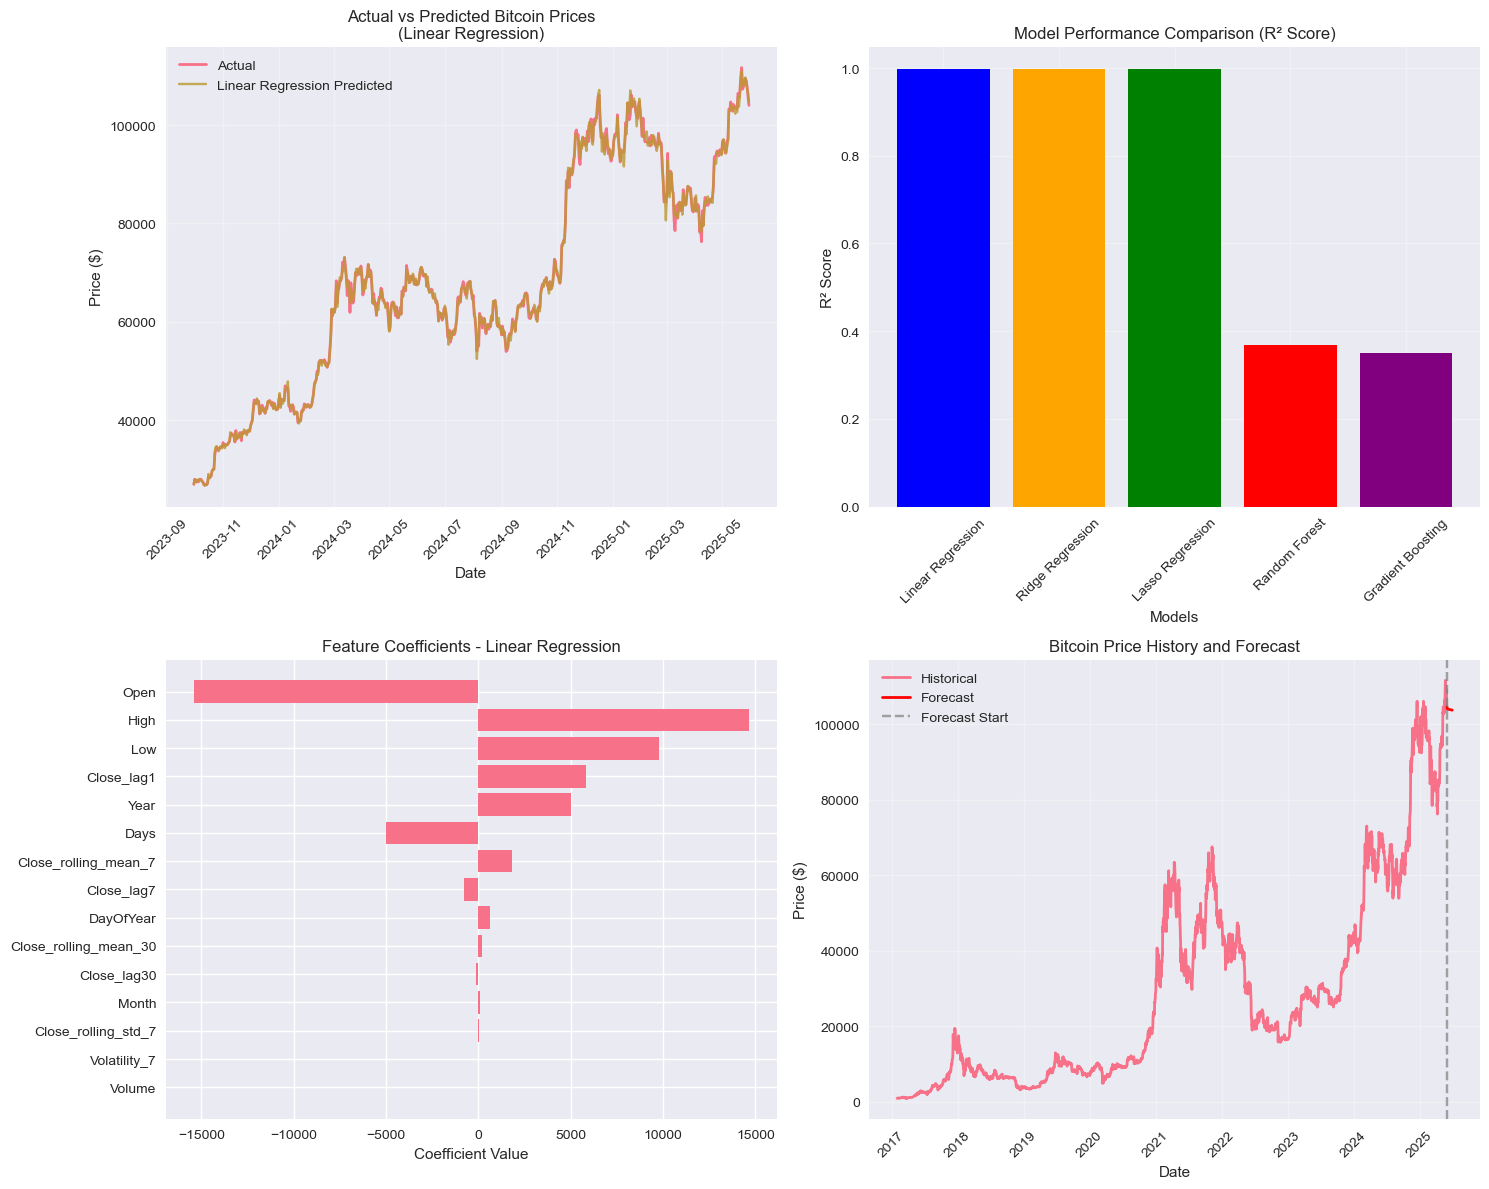


BITCOIN PRICE ANALYSIS SUMMARY
Total Period: 3071 days
Starting Price: $998.33
Ending Price: $103,998.57
Total Return: 10317.31%
Maximum Price: $111,673.28
Minimum Price: $777.76
Average Price: $28,445.38
Daily Volatility: 0.0368
Annualized Volatility: 0.7040

Best Model for Prediction: Linear Regression
Prediction Accuracy (R²): 0.9988
Average Prediction Error: $517.81


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
df = pd.read_csv(r"D:\desktop - new\Bitcoin\bitcoin_data.csv")

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Display basic info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Days: {(df['Date'].max() - df['Date'].min()).days}")
print("\nFirst few rows:")
print(df.head())
print("\nLast few rows:")
print(df.tail())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Create features for time series analysis
df['Days'] = (df['Date'] - df['Date'].min()).dt.days
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear

# Create lag features for time series prediction
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag7'] = df['Close'].shift(7)
df['Close_lag30'] = df['Close'].shift(30)

# Create rolling statistics
df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()
df['Close_rolling_std_7'] = df['Close'].rolling(window=7).std()
df['Close_rolling_mean_30'] = df['Close'].rolling(window=30).mean()

# Calculate daily returns and volatility
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_7'] = df['Daily_Return'].rolling(window=7).std()

# Drop rows with NaN values from lag features
df_clean = df.dropna().copy()

print(f"\nData after cleaning: {df_clean.shape}")

# Feature selection for regression
feature_columns = [
    'Days', 'Year', 'Month', 'DayOfYear',
    'Close_lag1', 'Close_lag7', 'Close_lag30',
    'Close_rolling_mean_7', 'Close_rolling_std_7', 'Close_rolling_mean_30',
    'Volatility_7', 'Open', 'High', 'Low', 'Volume'
]

X = df_clean[feature_columns]
y = df_clean['Close']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data - use 80% for training, 20% for testing
split_idx = int(0.8 * len(df_clean))
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    predictions[name] = y_pred
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"\n{name} Performance:")
    print(f"  MSE: {mse:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAE: {mae:,.2f}")
    print(f"  R²: {r2:.4f}")

# Find best model based on R² score
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
print(f"\nBest Model: {best_model_name} (R²: {results[best_model_name]['R2']:.4f})")

# Forecasting future prices
def forecast_future_prices(model, last_data, scaler, days=30, model_name=''):
    """Forecast future prices using the trained model"""
    future_predictions = []
    current_features = last_data.copy()
    
    for day in range(days):
        if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            features_scaled = scaler.transform(current_features.reshape(1, -1))
            pred = model.predict(features_scaled)[0]
        else:
            pred = model.predict(current_features.reshape(1, -1))[0]
        
        future_predictions.append(pred)
        
        # Update features for next prediction
        # This is a simplified approach - in practice you'd need more sophisticated logic
        current_features = update_features(current_features, pred, day)
    
    return future_predictions

def update_features(current_features, new_close, day):
    """Update features for next time step prediction"""
    # This is a simplified feature update logic
    # In practice, you'd want more sophisticated feature engineering
    updated = current_features.copy()
    
    # Update lag features
    updated[4] = new_close  # Close_lag1
    # Note: Other lag features would need more complex updating
    
    # Update days
    updated[0] += 1  # Days
    
    return updated

# Get the last available data point for forecasting
last_data_point = X_test.iloc[-1].values

# Forecast using the best model
best_model = models[best_model_name]
future_days = 30
future_prices = forecast_future_prices(
    best_model, last_data_point, scaler, future_days, best_model_name
)

print(f"\nForecasted prices for next {future_days} days:")
for i, price in enumerate(future_prices, 1):
    print(f"Day {i}: ${price:,.2f}")

# Visualization
plt.figure(figsize=(15, 12))

# Plot 1: Actual vs Predicted for best model
plt.subplot(2, 2, 1)
test_dates = df_clean['Date'].iloc[split_idx:split_idx + len(y_test)]
plt.plot(test_dates, y_test.values, label='Actual', linewidth=2)
plt.plot(test_dates, predictions[best_model_name], label=f'{best_model_name} Predicted', alpha=0.8)
plt.title(f'Actual vs Predicted Bitcoin Prices\n({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Model comparison
plt.subplot(2, 2, 2)
r2_scores = [results[model]['R2'] for model in models.keys()]
plt.bar(models.keys(), r2_scores, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Model Performance Comparison (R² Score)')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Feature importance for tree-based models
plt.subplot(2, 2, 3)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True)
    
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
else:
    # For linear models, show coefficients
    if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        coefficients = best_model.coef_
        coef_df = pd.DataFrame({
            'Feature': feature_columns,
            'Coefficient': coefficients
        }).sort_values('Coefficient', key=abs, ascending=True)
        
        plt.barh(coef_df['Feature'], coef_df['Coefficient'])
        plt.title(f'Feature Coefficients - {best_model_name}')
        plt.xlabel('Coefficient Value')
    else:
        plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Importance')

# Plot 4: Price trend with forecast
plt.subplot(2, 2, 4)
last_date = df_clean['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

plt.plot(df_clean['Date'], df_clean['Close'], label='Historical', linewidth=2)
plt.plot(forecast_dates, future_prices, label='Forecast', linewidth=2, color='red')
plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
plt.title('Bitcoin Price History and Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig("chart_name.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

# Additional analysis: Statistical summary
print("\n" + "="*50)
print("BITCOIN PRICE ANALYSIS SUMMARY")
print("="*50)
print(f"Total Period: {(df['Date'].max() - df['Date'].min()).days} days")
print(f"Starting Price: ${df['Close'].iloc[0]:,.2f}")
print(f"Ending Price: ${df['Close'].iloc[-1]:,.2f}")
print(f"Total Return: {((df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100):.2f}%")
print(f"Maximum Price: ${df['Close'].max():,.2f}")
print(f"Minimum Price: ${df['Close'].min():,.2f}")
print(f"Average Price: ${df['Close'].mean():,.2f}")

# Volatility analysis
daily_volatility = df_clean['Daily_Return'].std()
annualized_volatility = daily_volatility * np.sqrt(365)
print(f"Daily Volatility: {daily_volatility:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")

print(f"\nBest Model for Prediction: {best_model_name}")
print(f"Prediction Accuracy (R²): {results[best_model_name]['R2']:.4f}")
print(f"Average Prediction Error: ${results[best_model_name]['MAE']:,.2f}")